<a href="https://colab.research.google.com/github/ChengYuChuan/Studienarbeit/blob/main/Deep_Learning_SoSe2022_EntryTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Entry Task
1. Import all necessary packages

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

from torch.autograd import Variable
torch.manual_seed(0)

2. Load the Fashion MNIST dataset for image classification and show some samples
It is also available in PyTorch datasets and TensorFlow datasets


# 2.1 Loading the dataset

In [ ]:
ROOT = './data'
train_dataset = datasets.MNIST(root=ROOT,train=True,download=True,transform = transforms.ToTensor())
print("Print the training dataset:\n ", train_dataset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Print the training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
#we calculated our mean and standard deviation dor Torchvision's transforms
mean = train_dataset.data.float().mean() / 255
std = train_dataset.data.float().std() / 255
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


In [ ]:
#I know in the later part we have rotating part, but RandomRotation can increase 
#robustness of the dataset
#Here I did normalization also.

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

In [ ]:
train_dataset = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_dataset = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)
print("Print the validating dataset:\n ", test_dataset)
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

Print the validating dataset:
  Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
           )
Number of training examples: 60000
Number of testing examples: 10000


# 2.2 Visualizing the dataset

In [ ]:
def show_data(data_sample, shape = (28, 28)):
    plt.imshow(data_sample[0].numpy().reshape(shape), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))

In [ ]:
#print(train_dataset[0])

print(Variable(train_dataset[0][0]))

<class 'torchvision.datasets.mnist.MNIST'>


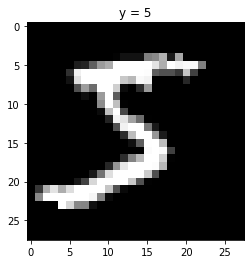

In [ ]:

print(type(train_dataset))
show_data(train_dataset[0])
plt.savefig('test.png', dpi=200)

# 3. Create a Multi Layer Perceptron (MLP) for image classification.

Feel free to use any configuration and framework for its implementation (Keras, Tensorflow, Pytorch, etc.)

In [ ]:
#create a validation set, taking 10% of the training set. 
VALID_RATIO = 0.9

n_train_examples = int(len(train_dataset) * VALID_RATIO)
n_valid_examples = len(train_dataset) - n_train_examples
#take a random 10% of the training set to use as a validation set.
train_dataset, valid_dataset = data.random_split(train_dataset,
                                           [n_train_examples, n_valid_examples])
#check it
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(valid_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [ ]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_dataset,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_dataset,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_dataset,
                                batch_size=BATCH_SIZE)
print(type(train_iterator))

<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))

        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)

        # y_pred = [batch size, output dim]

        return y_pred, h_2

In [ ]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 222,360 trainable parameters


# 4. Train the model

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 10
Train_loss_record = []
Train_acc_record = []
best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1_model.pt')
        torch.save(model.state_dict(), 'tut1_model.h5')
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    Train_loss_record.append(train_loss)
    Train_acc_record.append(train_acc)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 0.059 | Train Acc: 98.13%
	 Val. Loss: 0.084 |  Val. Acc: 97.68%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 0.058 | Train Acc: 98.14%
	 Val. Loss: 0.079 |  Val. Acc: 97.67%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 0.057 | Train Acc: 98.18%
	 Val. Loss: 0.072 |  Val. Acc: 97.88%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 0.055 | Train Acc: 98.22%
	 Val. Loss: 0.082 |  Val. Acc: 97.48%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 0.057 | Train Acc: 98.28%
	 Val. Loss: 0.071 |  Val. Acc: 97.97%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 0.052 | Train Acc: 98.26%
	 Val. Loss: 0.080 |  Val. Acc: 97.83%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 0.053 | Train Acc: 98.34%
	 Val. Loss: 0.079 |  Val. Acc: 97.70%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 0.052 | Train Acc: 98.38%
	 Val. Loss: 0.068 |  Val. Acc: 98.07%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 0.053 | Train Acc: 98.35%
	 Val. Loss: 0.085 |  Val. Acc: 97.69%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 21s
	Train Loss: 0.052 | Train Acc: 98.31%
	 Val. Loss: 0.079 |  Val. Acc: 97.93%


# 5. Plots
Plot the evolution of the Loss function and Accuracy values over the epochs during training.

Text(0.5, 1.0, 'evolution of the Loss function and Accuracy values')

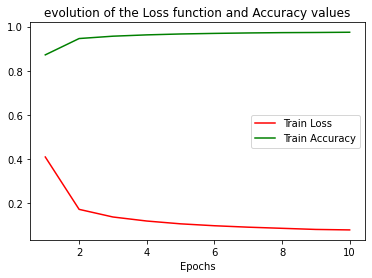

In [ ]:
X= np.linspace(1,EPOCHS,EPOCHS)
plt.plot(X,Train_loss_record,color='r',label='Train Loss')
plt.plot(X,Train_acc_record,color='g',label='Train Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.title("Evolution of the Loss function and Accuracy values")

# 6. Run inference
Run inference in the test set and compute the metrics for testing.

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.052 | Test Acc: 98.23%


# 7. Test samples
Show some samples from the test set: image, reference class and predicted class.

In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
example=[]
for image, label, prob, correct in zip(images, labels, probs, corrects):
    example.append((image,label,prob))

In [ ]:
def plot_SomeExample(example, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = example[i]
        true_prob = probs[true_label]
        example_prob, example_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {example_label} ({example_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

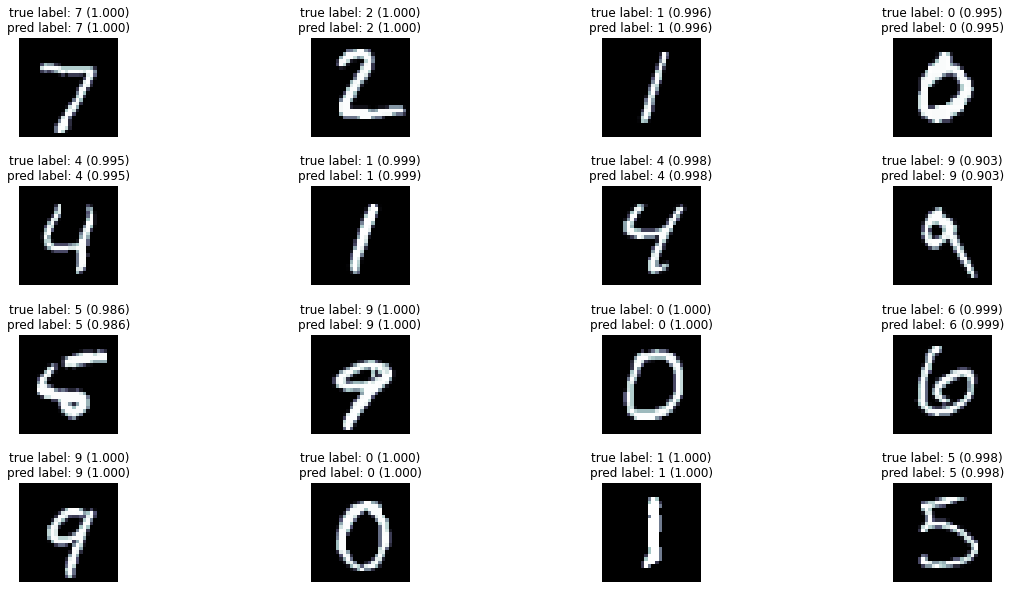

In [ ]:
N_IMAGES = 16

plot_SomeExample(example, N_IMAGES)

# 8. Testing with rotation
Choose one image from the test set, apply a rotation (e.g. 30°, 45°, 60°).

In [ ]:
test_transforms_30 = transforms.Compose([
                           transforms.RandomRotation((30,30)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

test_transforms_45 = transforms.Compose([
                           transforms.RandomRotation((45,45)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

test_transforms_60 = transforms.Compose([
                           transforms.RandomRotation((60,60)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

test_dataset_30 = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms_30)

test_dataset_45 = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms_45)

test_dataset_60 = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms_60)

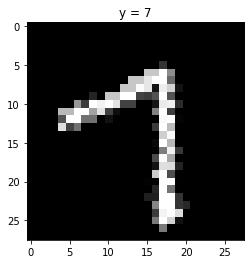

In [ ]:
show_data(test_dataset_30[0])

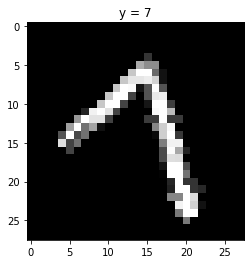

In [ ]:
show_data(test_dataset_45[0])

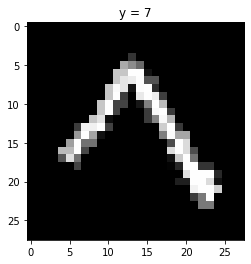

In [ ]:
show_data(test_dataset_60[0])

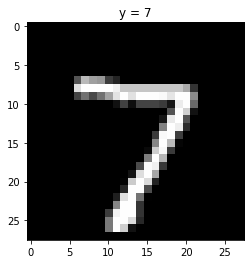

In [ ]:
show_data(test_dataset[0])

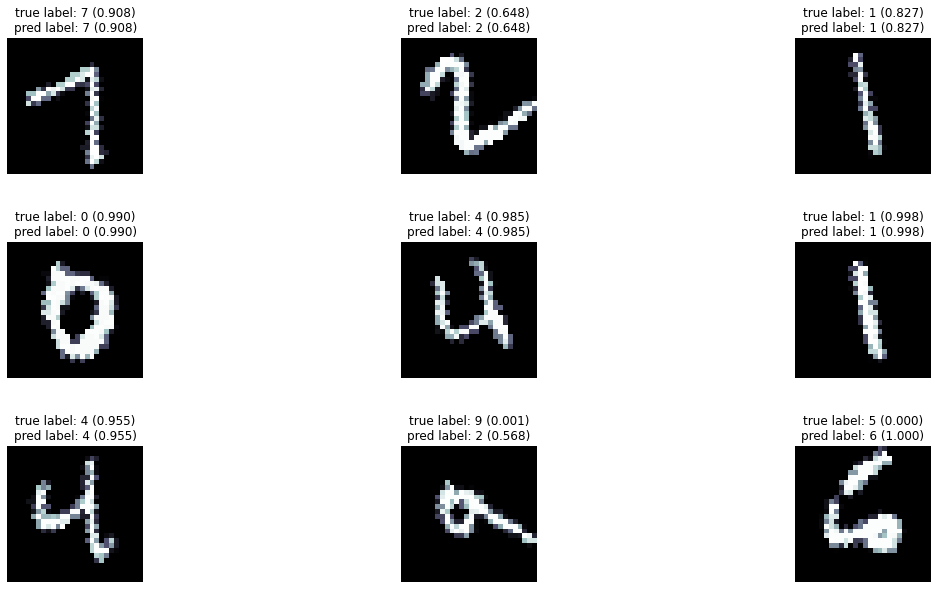

In [ ]:
test_iterator_30 = data.DataLoader(test_dataset_30,
                                batch_size=BATCH_SIZE)
images30,labels30,probs30 = get_predictions(model, test_iterator_30,device)
pred_labels_30 = torch.argmax(probs30, 1)
corrects30 = torch.eq(labels, pred_labels_30)

example30=[]
for image, labels, probs, correct in zip(images30, labels30, probs30, corrects30):
    example30.append((image,labels,probs))

N_IMAGES = 9

plot_SomeExample(example30, N_IMAGES)

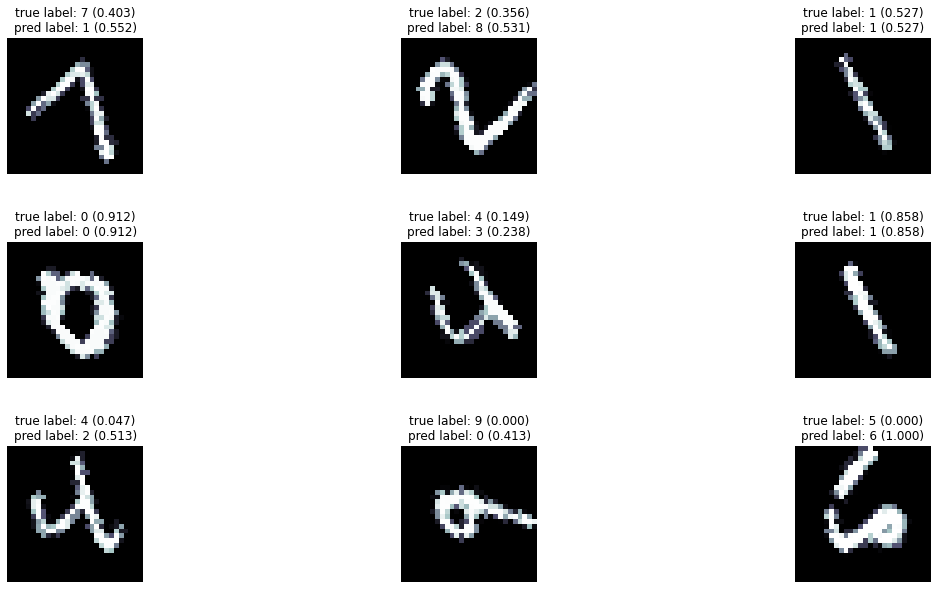

In [ ]:
test_iterator_45 = data.DataLoader(test_dataset_45,
                                batch_size=BATCH_SIZE)
images45,labels45,probs45 = get_predictions(model, test_iterator_45,device)
pred_labels_45 = torch.argmax(probs45, 1)
corrects45 = torch.eq(labels, pred_labels_45)

example45=[]
for image, labels, probs, correct in zip(images45, labels45, probs45, corrects45):
    example45.append((image,labels,probs))

N_IMAGES = 9

plot_SomeExample(example45, N_IMAGES)

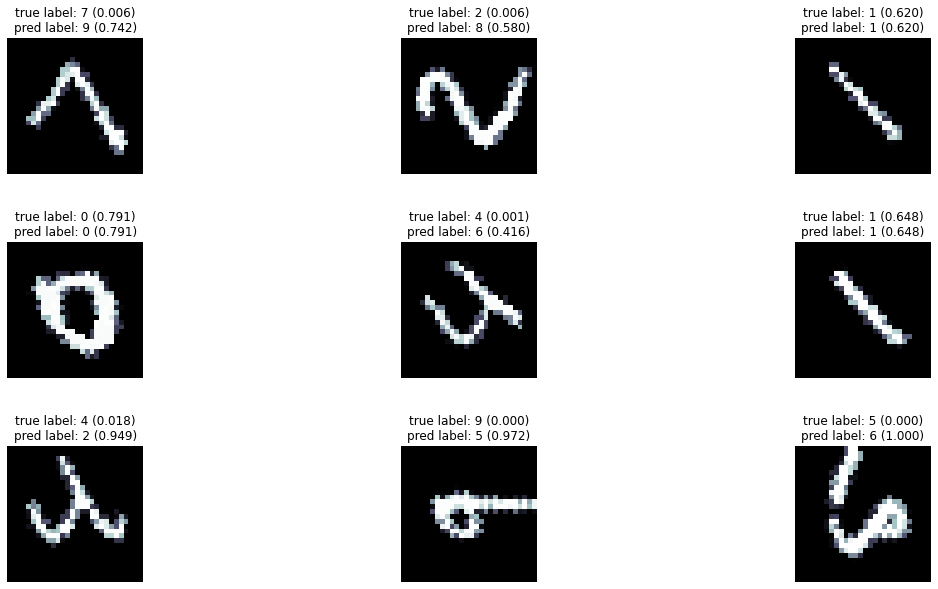

In [ ]:
test_iterator_60 = data.DataLoader(test_dataset_60,
                                batch_size=BATCH_SIZE)
images60,labels60,probs60 = get_predictions(model, test_iterator_60,device)
pred_labels_60 = torch.argmax(probs60, 1)
corrects60 = torch.eq(labels, pred_labels_60)

example60=[]
for image, labels, probs, correct in zip(images60, labels60, probs60, corrects60):
    example60.append((image,labels,probs))

N_IMAGES = 9

plot_SomeExample(example60, N_IMAGES)

# 9. Comparison
Compare the predicted classes before and after the rotation. Is there any change? If yes, what would be the reason for it?

yes, if we print the weight of 0 to 9, we will notice that handwritting does really depends on which direction we consier as top side.

# 10. Testing with new image
Test the model with another image (from internet or take a photo with your phone). Do not forget to convert the image to the Fashion MNIST format: grayscale, . 28 x 28 Comment the results.

In [ ]:
from PIL import Image
import tensorflow as tf
from google.colab import files
import cv2
uploaded = files.upload()

Saving handwritting_5.png to handwritting_5.png


(1, 28, 28, 1)


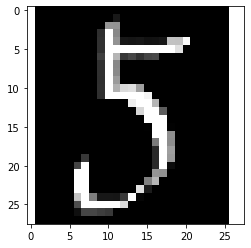

In [ ]:
image = tf.io.read_file('handwritting_5.png')
image = tf.image.decode_image(image,channels=3)
image = tf.image.rgb_to_grayscale(image, name=None)
resized_image = tf.image.resize_with_pad(image, 28, 28, antialias=False)
expanded_image = tf.expand_dims(resized_image, axis=0)
expanded_image = tf.cast(expanded_image, dtype=tf.float64)
print(expanded_image.shape)
plt.imshow(np.squeeze(resized_image), cmap=plt.cm.binary)

In [ ]:
prediction = model(expanded_image)

AttributeError: ignored

In [ ]:
processed_image=tf.concat([resized_image[0],resized_image[1], resized_image[2],resized_image[3],resized_image[4],resized_image[5],resized_image[6],resized_image[7],resized_image[8],resized_image[9],resized_image[10],resized_image[11],resized_image[12],resized_image[13],resized_image[14],resized_image[15],resized_image[16],resized_image[17],resized_image[18],resized_image[19],resized_image[20],resized_image[21],resized_image[22],resized_image[23],resized_image[24],resized_image[25],resized_image[26],resized_image[27]], 1)
processed_image=processed_image.numpy()
processed_image=torch.from_numpy(processed_image)
mydataset=(processed_image)
#print(mydataset)
expanded_mydataset=tf.constant([[[255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         178.8035, 178.8035, 224.7946, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,  64.5936,
           0.0000,   0.0000,   0.0000,   0.0000,  51.2454, 204.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 191.5000,  50.8394,
          48.9823,   0.0000,   0.0000,   0.0000,   0.0000, 184.5000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 162.3303,   0.0000, 184.5000, 255.0000],
        [255.0000, 255.0000, 255.0000, 215.7858, 213.8572, 214.3393, 201.5893,
         214.0179, 213.8572, 214.6607, 214.3393, 215.1429, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 232.0000,   0.0000, 191.7857, 255.0000],
        [255.0000, 255.0000, 161.1562,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 232.0000,   0.0000, 190.5000, 255.0000],
        [255.0000, 226.0714,  20.4467,  22.6788,  20.6253,   0.0000,  14.1520,
          22.6788,  22.2324,  19.1074,  15.0895,   0.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 233.6429,   0.0000, 245.1429, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 232.0000,   0.0000, 187.9286,
         255.0000, 255.0000, 255.0000,  44.3170,   0.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 233.0491,  23.0491, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 232.0000,   0.0000, 184.5000,
         255.0000, 255.0000, 255.0000,  26.6250,   0.0000, 226.5940, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000,  13.5000, 123.0132, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 234.0714,   0.0000, 185.9464,
         255.0000, 255.0000, 255.0000,  32.8393,   0.0000,  11.7679, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000,  37.6295, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 232.0000,   0.0000, 187.9286,
         255.0000, 255.0000, 255.0000, 180.2455,   0.0000,   0.0000,   0.3214,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000,   2.7232, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 238.4643,   0.0000, 200.7857,
         255.0000, 255.0000, 255.0000, 255.0000,  16.5223,   0.0000,   0.0000,
           0.0000, 222.1428, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000,  36.3168, 249.6206, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 234.5000,   0.0000, 180.5625,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000,  75.2500,   0.0000,
           0.0000,   0.0000,   0.0000,  72.8750, 162.0000, 161.6250, 162.0000,
          41.4062, 135.2812, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 232.6429,   0.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 169.3262,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
         118.4244, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000,  75.7812,   0.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 241.2500,  75.5893,  77.1072,  64.9643,  67.6206, 207.2188,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000,  62.1250,  17.2232, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000,  18.7500, 201.7635, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 170.5317, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000],
        [255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000,
         255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000]]])

In [ ]:
#from tensorflow.python.ops.gen_array_ops import reshape
from keras.models import Sequential, load_model
from keras.utils import np_utils
#expanded_mydataset=expanded_mydataset.numpy()
prediction = model(expanded_mydataset)
print(expanded_mydataset.shape)
#reshape_mydataset=expanded_mydataset.reshape(1,784)
#reshape_mydataset=reshape_mydataset.astype('float32')
#reshape_mydataset/=255
#print(reshape_mydataset)

AttributeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls /content/gdrive/MyDrive/Colab_files

tut1_model.h5


In [ ]:
from tensorflow import keras
mnist_model = torch.load('tut1_model.h5')
mnist_model(reshape_mydataset)
#mnist_model = load_model('tut1_model.h5')
#predicted_classes = mnist_model.predict_classes(reshape_mydataset)

TypeError: ignored

In [ ]:
#print("The tensor after converting:", processed_image[0])
#print("Mydataset:", mydataset)
print("Shape of mydataset:",processed_image.shape)
#print("Type after converting: ", processed_image.dtype)

In [ ]:
print(len(mydataset[0]))

28


In [ ]:
BATCH_SIZE=1
my_iterator = data.DataLoader(mydataset,
                                batch_size=BATCH_SIZE)
print(type(my_iterator))

<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
mnist_model = load_model(tut1-model.h5)

# 11. How could we improve the trained model?

There are many methods we learned in the course. For example: Dropout, Initialization, adjusting batch sizes and using different optimizer rather than Adam